# Plan of Action

**Our age prediction CNN model shall be defined and trained by**:
1. Importing **training and test datasets** from Google Drive Input Sub-folder
2. **Training dataset is already augmented** and has 234,000 images
3. **Greyscaling images** instead of using RGB color images
4. Defining our intuitively **distributed classes of age-ranges**
5. Using **60 epochs** on our **optimized CNN Architecture**, comprising of:
    - an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
    - 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
    - a *GlobalAveragePooling2D* layer,
    - 1 *Dense* layer with 132 nodes, and
    - an output *Dense* layer with 7 nodes.

# Mount Google Drive & Imports

In [5]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


np.random.seed(42)
tf.random.set_seed(42)
print("Done")

Done


# Data Preparation

## Import Dataset

In [6]:

train_aug_df = pd.read_csv("images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("images_filenames_labels_test.csv")
print("Done")

Done


## Know your Dataset

In [7]:
train_aug_df.head()

,filename,age
0,C:/Users/Rohit/Desktop/New folder(2)/combined_...,71
1,C:/Users/Rohit/Desktop/New folder(2)/combined_...,6
2,C:/Users/Rohit/Desktop/New folder(2)/combined_...,18
3,C:/Users/Rohit/Desktop/New folder(2)/combined_...,25
4,C:/Users/Rohit/Desktop/New folder(2)/combined_...,26


In [8]:
test_df.head()

,filename,age
0,C:/Users/Rohit/Desktop/New folder(2)/combined_...,8
1,C:/Users/Rohit/Desktop/New folder(2)/combined_...,38
2,C:/Users/Rohit/Desktop/New folder(2)/combined_...,40
3,C:/Users/Rohit/Desktop/New folder(2)/combined_...,36
4,C:/Users/Rohit/Desktop/New folder(2)/combined_...,8


In [9]:
train_aug_df.shape

(234399, 2)

In [10]:
test_df.shape

(10046, 2)

## Define Age Classes

In [11]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [12]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [13]:
train_aug_df.head(8)

,filename,age,target
0,C:/Users/Rohit/Desktop/New folder(2)/combined_...,71,6
1,C:/Users/Rohit/Desktop/New folder(2)/combined_...,6,1
2,C:/Users/Rohit/Desktop/New folder(2)/combined_...,18,2
3,C:/Users/Rohit/Desktop/New folder(2)/combined_...,25,3
4,C:/Users/Rohit/Desktop/New folder(2)/combined_...,26,3
5,C:/Users/Rohit/Desktop/New folder(2)/combined_...,26,3
6,C:/Users/Rohit/Desktop/New folder(2)/combined_...,3,1
7,C:/Users/Rohit/Desktop/New folder(2)/combined_...,33,4


In [14]:
test_df.head()

,filename,age,target
0,C:/Users/Rohit/Desktop/New folder(2)/combined_...,8,1
1,C:/Users/Rohit/Desktop/New folder(2)/combined_...,38,4
2,C:/Users/Rohit/Desktop/New folder(2)/combined_...,40,4
3,C:/Users/Rohit/Desktop/New folder(2)/combined_...,36,4
4,C:/Users/Rohit/Desktop/New folder(2)/combined_...,8,1


## Organize Dataset

In [15]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [16]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

# Image Greyscale Function

In [17]:
num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    
    label = tf.one_hot(label, num_classes)

    return image_decoded, label
print("Done")

Done


In [18]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(33)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(128)  
print("Done")  # Same as batch_size hyperparameter in model.fit() below.

Done


# CNN Architecture

In [19]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()
print("Done")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [20]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Done")

Done


In [21]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"cnn_logs")
print("Done")

Done


We shall also use ***ModelCheckpoint*** as a callback while training the final CNN model so as to be able to save the model as it continues training and improving in performance over 60 epochs.

In [22]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )
print("Done")

Done


# Model Fitting

In [23]:
# Fitting the above created CNN model.

cnn = final_cnn.fit(train_aug_dataset,
                                  batch_size = 128,
                                  validation_data=test_dataset,
                                  epochs=5,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    
                                 )
print("Done")

Epoch 1/5


7103/7103 [==============================] - ETA: 0s - loss: 1.1757 - accuracy: 0.5111
Epoch 1: val_accuracy improved from -inf to 0.60711, saving model to age_model_checkpoint.h5
7103/7103 [==============================] - 588s 81ms/step - loss: 1.1757 - accuracy: 0.5111 - val_loss: 0.9306 - val_accuracy: 0.6071
Epoch 2/5
7103/7103 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.6323
Epoch 2: val_accuracy improved from 0.60711 to 0.65091, saving model to age_model_checkpoint.h5
7103/7103 [==============================] - 541s 76ms/step - loss: 0.8613 - accuracy: 0.6323 - val_loss: 0.8254 - val_accuracy: 0.6509
Epoch 3/5
7103/7103 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.6698
Epoch 3: val_accuracy improved from 0.65091 to 0.67937, saving model to age_model_checkpoint.h5
7103/7103 [==============================] - 544s 77ms/step - loss: 0.7673 - accuracy: 0.6698 - val_loss: 0.7556 - val_accuracy: 0.6794
Epoch 4/5
7103/7103 [=====

# Checking Model Performance

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = cnn.history['loss']
test_loss = cnn.history['val_loss']
train_accuracy = cnn.history['accuracy']
test_accuracy = cnn.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

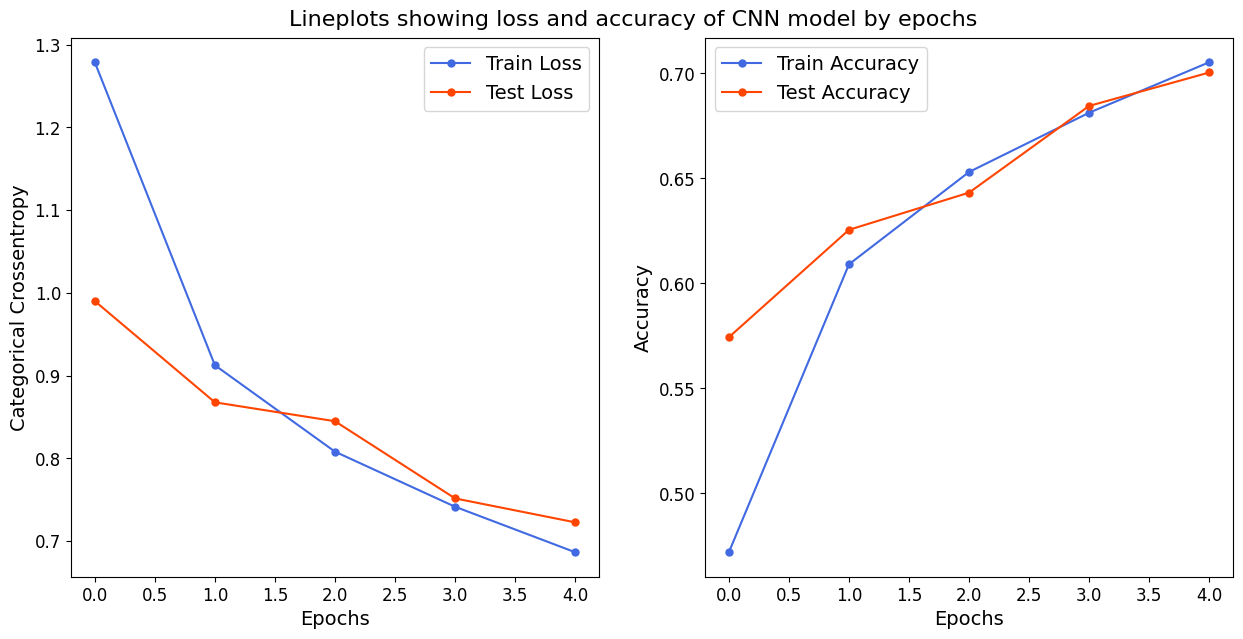

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.


In [ ]:
# Evaluating the model on test dataset.

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

NameError: name 'final_cnn' is not defined

In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.723
CNN model accuracy 	= 0.7


### Plotting Confusion Matrix

In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset[0])
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

NameError: name 'final_cnn' is not defined

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 909,   46,    0,    1,    2,    0,    0],
       [ 110,  686,   34,   12,    1,    2,    0],
       [   1,  182,  540,  170,   47,    1,    0],
       [   2,    9,  143, 1294,  547,    9,    3],
       [   0,   17,   61,  551, 2020,  149,    9],
       [   0,    3,   15,   15,  507,  949,  190],
       [   3,    2,    1,    2,   23,  139,  639]], dtype=int64)

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.


Normalized confusion matrix


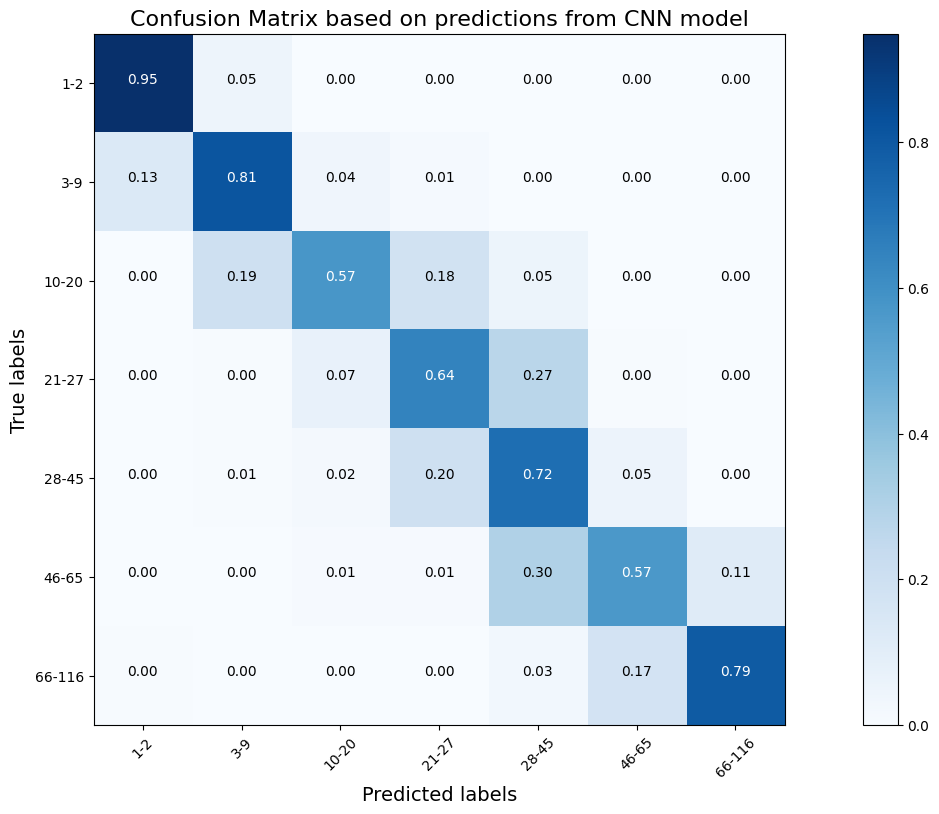

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Below is the **final summary of age prediction CNN model**.


As with any data science workflow, the deep learning approach presented above does have its own limitations as well. For instance, the original datasets used in this project only had about 33,000 images when combined together. Even though the training dataset was augmented to increase it's size from 23,440 images to 234,400 images, there is always a possibility that an **even larger training dataset with more variation in the images would have resulted in even better results**.

Another approach to this project could be to use **Transfer Learning (using the architecture and layer weights from a pre-trained neural network)** instead of creating and training a neural network from scratch.

Ref: https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2 by Prerak Agarwal